In [1]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from tensorflow import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
from keras.layers import LSTM ,Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from keras.regularizers import L1L2
from tensorflow.keras.models import load_model
from numpy.random import seed

In [144]:
seed(42)
tf.random.set_seed(42)

In [63]:

# moving average calculation
def moving_average(dataframe, window_size):
    
    #window_size = 4
    #tot = sales['Total].tolist()
    i = 0
    moving_averages = []
    while i < len(dataframe['Total']) - window_size + 1:
        this_window = dataframe['Total'][i : i + window_size]
        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += 1

    sales = pd.DataFrame(moving_averages, columns=['Total'])
    return sales

#adding lag to the sales for multistep forecasting
def lags(dataframe, lags):
    for lag in range(1,lags):
        col_name = 'lag_' +str(lag)
        dataframe[col_name] = dataframe['sales_norm'].shift(lag)
    #drop null val
    dataframe = dataframe.dropna().reset_index(drop = True)
    return dataframe

# tain and test dataset
def split_train_test(dataframe,trainsize):
    """ This function splits the dataframe in to train and test sets and converts in to LSTM readable format
    It needs 2 input: 
        1. Dataframe to split the dta into train and test
        2. trainsize in percentage ratio.
            eg: if you want 80% of the data as training then plug in 0.8"""

    train = dataframe[: int(len(dataframe)*trainsize)].values
    test =  dataframe[int(len(dataframe)*trainsize):].values
    X_train = train[:, 1:]
    y_train = train[:, 0:1]
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = test[:, 1:]
    y_test = test[:, 0:1]
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    return X_train, y_train, X_test, y_test


In [82]:
sales_tot = pd.read_csv('./data/sales_full.csv', index_col=0)
#sales_tot.head()
sales_tot = sales_tot.drop(['year','week','weeks'], axis = 1)
sales_ = sales_tot.copy()

In [83]:
sales_.head()

,Total
0,37640.0
1,19520.0
2,1270.0
3,2700.0
4,3560.0


Epoch 1/1000
12/12 [==============================] - 8s 119ms/step - loss: 0.0480 - val_loss: 0.0096
Epoch 2/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0311 - val_loss: 0.0051
Epoch 3/1000
12/12 [==============================] - 0s 12ms/step - loss: 0.0288 - val_loss: 0.0062
Epoch 4/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0283 - val_loss: 0.0063
Epoch 5/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0259 - val_loss: 0.0055
Epoch 6/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0265 - val_loss: 0.0066
Epoch 7/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0259 - val_loss: 0.0058
Epoch 8/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0263 - val_loss: 0.0071
Epoch 9/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0266 - val_loss: 0.0063
Epoch 10/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0266 - val_los

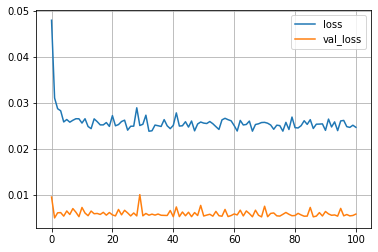

Model Evalution Score
1/1 [==============================] - 2s 2s/step - loss: 0.0181
0.018125420436263084


28747.958762385286

In [75]:


#sales = moving_average(sales_, 1)
# normalize the dataset
scaler = MinMaxScaler()
sales_norm = scaler.fit_transform(sales_.Total.values.reshape(-1, 1))

sales_['sales_norm'] = sales_norm

sales_ = sales_.drop(['Total'],axis = 1)

X_train, y_train, X_test, y_test = split_train_test(lags(sales_,6), 0.9)
K.clear_session()


model = Sequential()
model.add(Bidirectional(LSTM(64, activation = 'tanh', input_shape = ( X_train.shape[1], X_train.shape[2]), return_sequences=True)))
#model.add(Bidirectional(LSTM(512, activation = 'tanh', return_sequences = True)))
#model.add(Bidirectional(LSTM(256,activation = 'tanh', return_sequences = True)))
#model.add(Bidirectional(LSTM(128, activation = 'tanh', return_sequences = True)))
#model.add(Bidirectional(LSTM(64, activation = 'tanh', return_sequences = True)))
model.add(Bidirectional(LSTM(32, activation = 'tanh', return_sequences = False)))
model.add(Dropout(0.5))
#model.add(Dense(1024, activation = 'tanh'))
#model.add(Dense(512, activation = 'tanh'))#256,
#model.add(Dense(100, activation = 'tanh'))#256,128
model.add(Dense(50, activation = 'tanh'))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', 
                loss='mse')#metrics=['mse']

cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                    min_delta=0.01,
                                    patience=100,
                                    verbose=1,
                                    mode="min",
                                    baseline=None,
                                    restore_best_weights=False)

history = model.fit(X_train,y_train, 
                    epochs = 1000, 
                    batch_size = 8, 
                    validation_split=0.2, 
                    verbose = 1,
                    callbacks=[cb],
                    shuffle= True)

pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca() # set the y range to [0,1]
plt.show()
print('Model Evalution Score')
print(model.evaluate(X_test, y_test))

trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(y_test)

trainScore = math.sqrt(mean_squared_error(y_train[:,0], trainPredict[:,0]))
trainScore

testScore = math.sqrt(mean_squared_error(y_test[:,0], testPredict[:,0]))
testScore


In [77]:
model.save(r"..\models\model_trail.h5")


In [ ]:
forecast = []
last_row = X_test[-1:]
last_row

In [ ]:
pred = model.predict(last_row)

In [ ]:
pred[:,0].tolist()

In [ ]:
sales_[-5:]

In [84]:



#sales_mv_avg = moving_average(sales_,1)
#print(sales_mv_avg)
#sales = pd.DataFrame(sales_mv_avg, columns=['Total'])
#print(sales)
sales_.head()
scaler = MinMaxScaler()
sales_norm = scaler.fit_transform(sales_.Total.values.reshape(-1, 1))
sales_norm = sales_norm.flatten().tolist()
#print(sales_norm)
sales_['sales_norm'] = sales_norm
#print(sales)
sales = sales_.drop(['Total'],axis = 1)
#print(sales)
sales = lags(sales,6)
#print(sales)
#sales
last_row = sales[-1:]
last_row = last_row.drop(['sales_norm'], axis = 1)
last_row = last_row.to_numpy()
last_row = last_row.reshape(last_row.shape[0], 1, last_row.shape[1])
print(last_row.shape[0])
print(last_row)
model = load_model(r'.\models\model_trail.h5')

pred = model.predict(last_row)
#print(pred)
forecast = scaler.inverse_transform(pred)[:,0].tolist()
forecast = pd.DataFrame(forecast, columns = ['Total'])
forecast
sales_ = pd.concat([sales_, forecast], ignore_index=True)
sales_.tail()

#

1
[[[0.18395041 0.40112845 0.25384369 0.25262115 0.23043619]]]


InvalidArgumentError: Graph execution error:

Invalid input_h shape: [1,8,64] [1,1,64]
	 [[{{node CudnnRNN}}]]
	 [[sequential/bidirectional/forward_lstm/PartitionedCall]] [Op:__inference_predict_function_273848]

In [51]:
def forecasting(dataframe, window_size, lag, n_future):

    #dataframe = sales_
    #window_size = 4
    #lags = 6
    #n_future = number of weeks /days to forecast in future

    model = load_model(r'.\models\model_trail.h5') #model_mv_week_4
    scaler = MinMaxScaler()
    for n in range(n_future):
    
        sales = pd.DataFrame(moving_average(dataframe, window_size), columns=['Total'])
        sales_norm = scaler.fit_transform(sales.Total.values.reshape(-1, 1))
        sales_norm = sales_norm.flatten().tolist()
        sales['sales_norm'] = sales_norm
        sales = sales.drop(['Total'],axis = 1)
        sales = lags(sales,lag)
        last_row = sales[-1:]
        last_row = last_row.drop(['sales_norm'], axis = 1)
        last_row = last_row.to_numpy()
        last_row = last_row.reshape(last_row.shape[0], 1, last_row.shape[1]) #
        pred = model.predict(last_row)
        forecast = scaler.inverse_transform(pred)[:,0]#.tolist()
        forecast = pd.DataFrame(forecast, columns = ['Total'])
        dataframe = pd.concat([dataframe,forecast], ignore_index=True)
        dataframe.to_csv('./forecast_data/forecast_week_100.csv')
    print(dataframe) 

In [52]:
data = forecasting(sales_,1,6, 12)
type(data)


             Total
0     37640.000000
1     19520.000000
2      1270.000000
3      2700.000000
4      3560.000000
..             ...
147  153140.890625
148  173185.968750
149  153215.953125
150  130191.546875
151  164046.421875

[152 rows x 1 columns]


NoneType

In [58]:
def moving_average_(dataframe, window_size):
    
    #window_size = 4
    #tot = sales['Total].tolist()
    if window_size != 1:
        i = 0
        moving_averages = []
        while i < len(dataframe['Total']) - window_size + 1:
            this_window = dataframe['Total'][i : i + window_size]
            window_average = sum(this_window) / window_size
            moving_averages.append(window_average)
            i += 1

        sales = pd.DataFrame(moving_averages, columns=['Total'])

    else: 
        moving_averages = dataframe['Total']
        sales = pd.DataFrame(moving_averages, columns=['Total'])
    return sales

In [59]:
sales_tot = pd.read_csv('./data/sales_full.csv', index_col=0)
#sales_tot.head()
sales_tot = sales_tot.drop(['year','week','weeks'], axis = 1)
sales_ = sales_tot.copy()

In [61]:
moving_average_(sales_, 1)

,Total
0,37640.00
1,19520.00
2,1270.00
3,2700.00
4,3560.00
...,...
134,54187.70
135,54448.75
136,85898.76
137,39524.30
